# Titanic - Machine learning from Disaster


The aim of this exercise is to run through the concepts of Data Cleaning, exploring the data and test a few Machine learning model and check which work the best. 

Let's start by importing all the key libraries we are going to use while working with this project. 

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

Importing the train and the test sets now. We will analyse the training set, check if it needs any imputation for the missing values and also engineer some feature that we will use for our hypothesis. Oh, and yes, we'll follow some of these methods on the test set too!

In [82]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

combine = [train, test]

In [83]:
test_df = test.copy()
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Going through the dataset and check how much missing value it has. 

In [84]:
train.isnull().sum()/train.isnull().count().sort_values(ascending = False)

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

In [85]:
test.isnull().sum()/test.isnull().count().sort_values(ascending = False)

Age            0.205742
Cabin          0.782297
Embarked       0.000000
Fare           0.002392
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

We notice here, in addition to the "Age" missing values, we also a few in the "Fare". So we would also like to sort that out.

Cabin data has more than 75% of the data missing, so it makes no sense to impute and try find the missing the missing values. So we will drop the column now. Meanwhile, "Age" and "Embarked" have very less missing data and it is also possible that they can be imputed.

First we'll drop the Cabin data.

In [86]:
train.drop('Cabin', axis =1 , inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

Now, lets impute the missing data for Age. We will do that by extracting  the title of the Passenger from "Name" column into account. 

In [87]:
title = []
for dataset in combine:
    #dataset.loc[dataset['Name']]
    #for s in dataset['Name']:
    #    title.append((s.split(",")[1].split(".")[0].strip()))
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
#s['Title']= title
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


<AxesSubplot:xlabel='Title', ylabel='Age'>

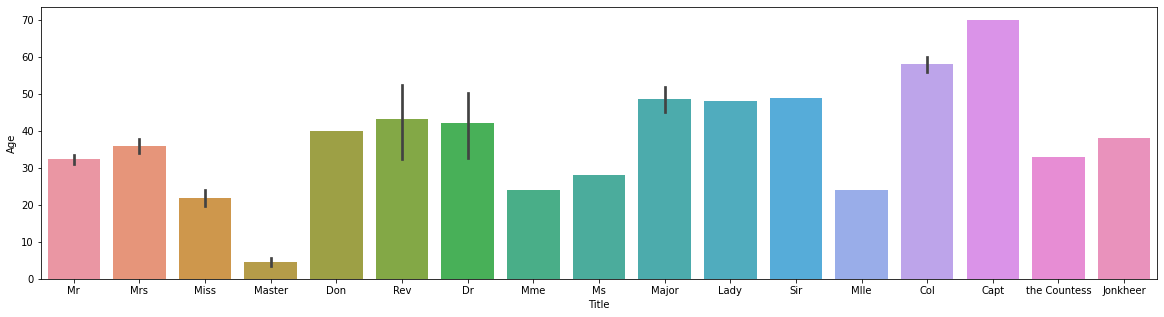

In [88]:
plt.figure(figsize = (20,5))
sns.barplot(x = train['Title'], y = train['Age'])

But we realise, and particularly for females, for an unmarried female and child females, the title is the the same -- "Miss". To get around this, we will first check the average age of the unmarried females and then that of child females.

We shall use the "Parch" column tells us whether the passenger has travelled with their parents or not. Using that, we'll deduce if the female is Female Child or just a Female. 

In [89]:
print("Avg age of 'Miss' Title travelling without Parents:", round(train[(train.Title=="Miss") & (train.Parch==0)]['Age'].mean()))

Avg age of 'Miss' Title travelling without Parents: 28


In [90]:
print ("Avg age of 'Miss' Title travelling with Parents:", round(train[(train.Title=="Miss") & (train.Parch!=0)]['Age'].mean()))

Avg age of 'Miss' Title travelling with Parents: 12


Now, we'll assign the title of the female child travelling without parents as Female Child and keep that of unmarried females as "Miss"

In [91]:
for dataset in combine:
    dataset.loc[(dataset.Title == "Miss") & (dataset.Parch!= 0), 'Title'] = "FemaleChild"

We will change the age of the Female Child to 12, fill the missing values in the Fare column in the test set. Fill the missing values in 'Embarked' column. 

Further, we shall have a new column in place as the Family Size which gives us an idea about the number of people travelling together & how that plays a part whether a person survives or not. & with the help of that, we can also deduce whether the person is travelling alone or with someone, just to have a comparison. 

In [92]:
for df in combine:
    
    df.loc[df['Title']== 'FemaleChild', 'Age'] = 12
    
    df['Fare'].fillna(df['Fare'].median(), inplace = True)
    
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    
    df['Family Size'] = df['SibSp'] + df['Parch']

    df['Lonely'] = np.where(df['Family Size']!= 0, 0,1)


In [93]:
train.head() #checking how our changes have worked.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Family Size,Lonely
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0,1


In [94]:
means = train.groupby(['Sex', 'Title'])
train.Age = means.Age.apply(lambda x: x.fillna(x.mean()))

means = test.groupby(['Sex', 'Title'])
test.Age = means.Age.apply(lambda x: x.fillna(x.mean()))


In [95]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            1
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Family Size    0
Lonely         0
dtype: int64

There is also a row in the test set where the value of Age is missing. Here, the title is Ms, so we will find the average of the all people with the title Ms in the train set and then set the lone missing value in the test.

In [96]:
train[(train.Title == "Ms")]['Age'].mean()

28.0

So we set the lone missing Age value in the test set as 28.

In [97]:
test.loc[test['Title']== 'Ms', 'Age'] = 28

In [98]:
#train.head()
#test.head()


# Exploratory Data Analysis

Now we have imputed and dealt with the missing values in both the datasets. So, we will proceed further to exploratory data analysis.

Our target variable is 'Survived', whether the passenger survives or not. We would like to see how many variables would play a big part in the survival of the passengers. For example, we know for a fact that in times of crisis, women and children are first looked after. So the chances of them surviving seem convincing. Hence, sex and age play a key part in the survival. At the same time, we know that the name of the Passenger or the Ticket number would not make any difference, so no need to include them into our analysis. 

Ofcourse, all this is our hypothesis, exploring the dataset furher would make our convictions stronger.

So, first up is the Pclass variable. Does it play a factor in survival? Let's see what the data tells us. 

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

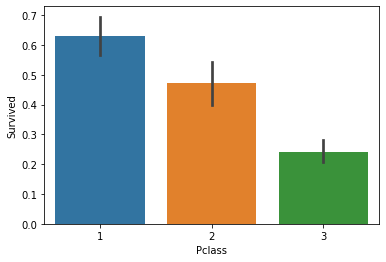

In [99]:
df = train.copy()
sns.barplot(x = df["Pclass"], y = df["Survived"])

So it does seem like Pclass plays a factor. Survival rate of the people in the Pclass 3 is very less; the barplot also shows a decreasing trend. 

Now we move to the Sex factor. We already have a hypothesis that Female have a better survival chance than Men. We'll see how true it is.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

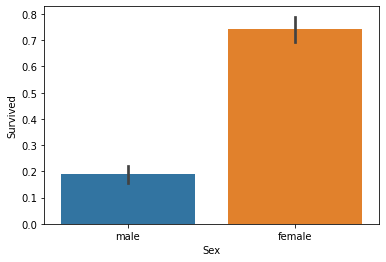

In [100]:
sns.barplot(x = df["Sex"], y = df["Survived"])

About more than 70% of the survival rate belongs to the Female category, thus confirming our hypothesis.

We know Age plays a big part in our study, so we'll look further onto this with a small viz. We will put the age data into several bins and explore the survival rate of each bin. 

<AxesSubplot:xlabel='age_bin', ylabel='Survived'>

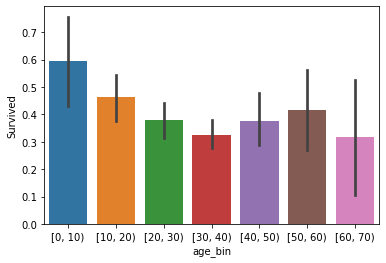

In [101]:
bins = [0,10,20,30,40,50,60,70]

df['age_bin'] = pd.cut(df['Age'], bins, right = False)

sns.barplot(x = df["age_bin"], y = df["Survived"])

Further confirming our hypothesis that children have had a better chance of surviving than any other age group in the dataset.

Next thing we would like to look at how much having a family help in your survival chances. We believe a collective effort would help in crisis like this. Contrarily, there are also a few who are on this cruise alone. How much does that affect? Let's see.

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Family Size', ylabel='Survived'>

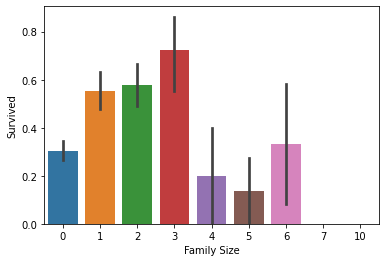

In [102]:
sns.barplot(df['Family Size'], df['Survived'])

Our takeaway should be that you would have a low survival chance had you travelled alone. While having a family member alogn with you gives you a good chance, interesting the chances decreases massively from around 70% to almost 20% when the family size is about 4. 

Looking at the some Quantitative variables next with the help of boxplot, histogram and violin plot. 

Variables we will be looking at are Fare, No. of Passengers and the Pclass.

Does paying paying higher amount of ticket play here? & how does it compare with the Pclass? Let's check.



D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

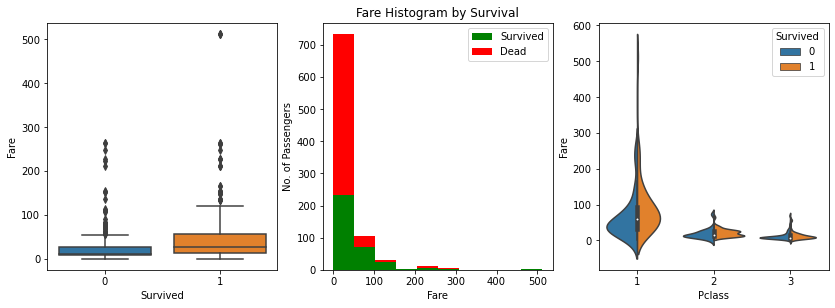

In [103]:
plt.figure(figsize=[14,10])

plt.subplot(231)
sns.boxplot(df['Survived'], df['Fare'])

plt.subplot(232)
plt.hist(x = [df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare')
plt.ylabel('No. of Passengers')
plt.legend()

plt.subplot(233)
sns.violinplot(x = "Pclass", y = "Fare", hue = "Survived", data= df, split = True)

So in the plot 'Survived vs Fare', we note that Fare does really play a role here; you pay more, the chances of your survival are high. 

In the Histogram, we observe a similar case. As you pay higher, your survival rate increases. 

Interestingly in the third plot, which is the violin, if you travel in the first class and pay more you have significant chances of survival. But same cannot be said about the class 2 and 3. Your survival chances remain the same even if you pay more.

Our final variable is the Embarked. We will see if people from different ports would have any better chances of survival. We will again do a barplot.

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

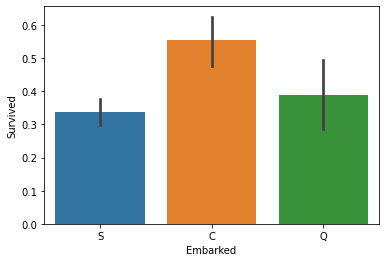

In [104]:
sns.barplot(df['Embarked'], df['Survived'])

Interesting results: people embarking on port C have had better chances of survival than the other ports. What does this mean? We should explore further by taking the amount of fare people have paid on each of the port. 

In [105]:
df.groupby(['Embarked'])['Fare'].mean()

Embarked
C    59.954144
Q    13.276030
S    27.243651
Name: Fare, dtype: float64

So, it seems like people on the Port C have played more amount of money than the others and thus had higher survival chances. 

From our results, it seems like having paid a higher fare and being in the class 1 does play a role in a passenger's survival chances.

# Next up: Model the data

So far we have performed Data cleaning, imputation, Exploratory Data Analysis, feature extraction and engineering. Now we will model the data next.

In order to model the data first, we need to first get rid of some of the irrelevant features that we have so we do not introduce them in the model. One of the reasons we do not want these features is because we believe they would not influence the outcome (survive or dead) and including them might introduce bias or overfitting into model. 

So we drop some of the features. 

Although some of them are self-explanatory, while some such as 'SibSp' & 'Parch' have been removed and been replaced by the feature we engineered - 'Family size'.

We will also convert the variables such as 'Sex' and 'Embarked' which are qualitative in nature to Categorical values using the Pandas feature. Also, we will also convert them to dummy variable.

In [106]:
for df in combine:
    df.drop('Name', axis = 1, inplace = True)
    df.drop('Ticket', axis =1, inplace = True)
    df.drop('Title', axis = 1, inplace = True)
    df.drop('PassengerId', axis = 1, inplace = True)
    df.drop('SibSp', axis = 1, inplace =  True)
    df.drop('Parch', axis = 1, inplace = True)
    #df.drop('Family Size', axis= 1, inplace = True)
    
    df['Sex'] = pd.Categorical(df['Sex'])
    df['Embarked'] = pd.Categorical(df['Embarked'])
    #df['Lonely'] = pd.Categorical(df['Lonely'])
    
    #df = pd.get_dummies(df, drop_first = True)

In [107]:
#Convert categorical to dummy 

train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [108]:
train.head()

,Survived,Pclass,Age,Fare,Family Size,Lonely,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,0,1,0,1
1,1,1,38.0,71.2833,1,0,0,0,0
2,1,3,26.0,7.9250,0,1,0,0,1
3,1,1,35.0,53.1000,1,0,0,0,1
4,0,3,35.0,8.0500,0,1,1,0,1


In [109]:
test.head()

,Pclass,Age,Fare,Family Size,Lonely,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,7.8292,0,1,1,1,0
1,3,47.0,7.0000,1,0,0,0,1
2,2,62.0,9.6875,0,1,1,1,0
3,3,27.0,8.6625,0,1,1,0,1
4,3,22.0,12.2875,2,0,0,0,1


Get train and test sets using the sklearn feature train test split

In [110]:
X = train.loc[:, train.columns!= "Survived"]
y=  train['Survived']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .2, random_state = 2206)

To scale the data, we will use the MinMaxScaler. This will scale the data in any given range. example: between zero and one.

In [111]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X)
scaled_test = scaler.transform(Xtest)

Now that the data has been scaled. We will develop our machine learning model and pass on our scaled data to the model to predict. 

Now, how do we choose the model that works the best for our data? Obviously there are is no particular best model. We have to try and check which works best for our data. 

We shall first check with the Logistic regression. Even though it is named regression, it is a classifier which would help us classify if the passenger survives or not. 

In [112]:
log_reg = LogisticRegression(solver = "liblinear", max_iter = 100)
log_reg.fit(Xtrain, ytrain)

scores = cross_val_score(log_reg, Xtrain, ytrain, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.794 +/- 0.025


We achieve an accuracy of 79% here. Can we improve on this with the data we have? Probably. Let's check how we fair with a Random forest classifier.

In [113]:
rc = RandomForestClassifier(n_estimators = 1000)
rc = rc.fit(Xtrain, ytrain)
ypred = rc.predict(Xtest)

print("Accuracy: {}".format(metrics.accuracy_score(ytest, ypred)))

Accuracy: 0.7932960893854749


It's just a decision tree but except one here we have many random decision trees or a forest. It is an ensemble method and uses bagging.

This gives us much better peformance with an accuracy of ~80%

Next we will give our try is with the Gradient Boosting classifier. The idea of this is to minimise the loss function.

In [114]:
gbk = GradientBoostingClassifier()
gbk.fit(Xtrain, ytrain)
ypred = gbk.predict(Xtest)

print("Accuracy: {}".format(metrics.accuracy_score(ytest, ypred)))

Accuracy: 0.8603351955307262


This very much improves our accuracy over the random forest, giving 86%.

In [115]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [116]:
#set ids as PassengerId and predict survival 
ids = test_df['PassengerId']
predictions = gbk.predict(test)

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

Thus, we reach an end to our project. We have completed a thorough analysis of the dataset with some visualisations. We have performed Data cleaning and imputation with the missing values.

Our takeaway here should be - We could achieve a most 84% or 81% accuracy on the training set. But we should bare in mind the size of the data at our disposal. For our model to work the best, it also needs to learn more, have more of the data so it produces results on the unseen data. 

For me the most important learning curve was visualisations using matplotlib and seaborn. Transforming the dataset using pandas - like feature engineering, extraction, querying the dataset in particular too.

The Stackoverflow community, the medium and towards data science are a great place to learn, mainly for Data Science and programming too. Wouldn't have been possible without them.  